## Swin_Transformer复现
本文基于原论文内容复现，用于学习及复习使用，与文章的原始代码实现方法及模型输入输出维度有很大的区别，请谨慎参考。论文原始代码请参考：[Swin-Transformer](https://github.com/microsoft/Swin-Transformer/blob/main/models/swin_transformer.py)

#### 1、embedding层的构建
拉平图片的每一个patch为向量，并展平每一个窗口，输出的维度为B\*C\*N\*D，即batch的维度，窗口的个数，每个窗口中patch的个数，每个patch的维度。

In [1]:
import torch
from torch import nn
from typing import Any, List, Callable, Tuple

class Embedding(nn.Module):
    '''
    doc of embedding layer:
    拉平图片的每一个patch为向量，并展平每一个窗口，输出的维度为B*C*N*D；
    即batch的维度，窗口的个数，每个窗口中patch的个数，每个patch的维度。
    args:
        pic_shape: Tuple[int, int, int]
        patch_size: int=4
        win_size: int=7
    example:
        x = torch.rand(2,3,224,224) # B,C,H,W
        flat = Embeeding(pic_shape=(3,224,224), patch_size=4, win_size=7)
        x = flat(x)
    '''
    def __init__(self, pic_shape: Tuple[int, int, int]=(3,224,224), patch_size: int=4, win_size: int=7):
        super(Embedding, self).__init__()
        self.pic_size = pic_shape[-2:] # h*w 224*224
        self.pic_channel = pic_shape[-3] # c 3
        self.win_shape = int((pic_shape[-1]/(patch_size*win_size))**2) # n 64
        self.win_size = win_size # win_size 7
        self.dim_size = patch_size**2*self.pic_channel # dim 16*16*3=48
        self.unfold = nn.Unfold(kernel_size=win_size, dilation=1, padding=0, stride=win_size)
        self.encoder = nn.Conv2d(
            self.pic_channel,
            self.dim_size,
            kernel_size=patch_size,
            stride=patch_size
        )
        
    def forward(self, x: Any):
        # ->batch_size * window_num * patch_num * dim
        result = self.unfold(self.encoder(x)).permute(0,2,1).reshape(
            -1,
            self.win_shape,
            self.dim_size,
            self.win_size**2
        ).permute(0,1,3,2).contiguous()
        return result

x = torch.rand(2,3,224,224)
flat = Embedding()
x = flat(x)
x.shape

torch.Size([2, 64, 49, 48])

每一个stage的全连接层，以Swin-T，输入图片尺寸224为例，第一个stage将嵌入的48个维度升到96d，第二个stage将96d变为192d，第三个stage将192d变为384d，第四个stage将384d变为768d

In [2]:
# 本段代码仅在测试阶段使用并不包含在整个模型中
class Dense(nn.Module):
    def __init__(self, in_channle: int, out_channle: int, norm_shape: int):
        super(Dense, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_channle, out_channle),
            nn.LayerNorm((out_channle))
        )
        
    def forward(self, x):
        return self.encoder(x)
    
dense = Dense(x.shape[3], 96, x.shape[-2])
x = dense(x)
x.shape

torch.Size([2, 64, 49, 96])

#### 2、多头自注意力层的构建
##### 1）shifted windows操作
该类实现平移窗口操作，返回平移后的mask，给不同区域patch的qk注意力矩阵做mask掩码

In [3]:
# shifted mask
import math

class Shifted_Window:
    '''
    doc of Shifted_Window:
    该类实现平移窗口操作，返回平移后的mask，给不同区域patch的qk注意力矩阵做mask掩码
    args:
        input_shape: Tuple[int, int]=(224,224)
        window_size: int=7
        patch_size: int=4
        mask: bool=False
    example:
        shift = Shifted_Window(input_shape=(32,32), window_size=4, patch_size=1, mask=True)
        mask = shift.get_mask()
    '''
    def __init__(self, input_shape: Tuple[int, int]=(224,224), window_size: int=7, patch_size: int=4, mask: bool=False):
        self._window_size = window_size
        self._input_shape = input_shape
        self._window_num = (math.ceil(self._input_shape[0] / (window_size*patch_size)),
                            math.ceil(self._input_shape[0] / (window_size*patch_size)))
        self._patch_size = patch_size
        self.mask = mask
        self._shift_size = self._window_size//2
        if mask:
            self.mat_index = torch.zeros((self._input_shape[0]//patch_size, self._input_shape[1]//patch_size))
            self.w_index = torch.arange(0, (self._window_num[0]+1)*window_size+1, window_size)-window_size+(window_size//2)
            self.h_index = torch.arange(0, (self._window_num[1]+1)*window_size+1, window_size)-window_size+(window_size//2)
            for i in range(self._window_num[0]+1):
                for j in range(self._window_num[1]+1):
                    self.mat_index[max(0, int(self.w_index[i].item())):min(int(self.w_index[i+1].item()),self._input_shape[0]),
                                   max(0, int(self.h_index[j].item())):min(int(self.h_index[j+1].item()),self._input_shape[1])]\
                    = i*(self._window_num[0]+1)+j
    
    
    @staticmethod
    def _get_chip(m, size_h, size_w, size_win):
        chip_list = []
        for i in range(size_w):
            for j in range(size_h):
                chip_list.append(m[i*size_win:min((i+1)*size_win, size_w*size_win),
                                   j*size_win:min((j+1)*size_win, size_h*size_win)])
        return chip_list
    
    def get_mask(self):
        return_mask = []
        assert self.mask, "not cyclic mode"
        self.mat_index =  torch.roll(self.mat_index, shifts=(-self._shift_size, -self._shift_size), dims=(-2, -1))
        for i in Shifted_Window._get_chip(self.mat_index, self._window_num[0], self._window_num[1], self._window_size):
            tmp_mat = torch.meshgrid(i.flatten(), i.flatten())
            tmp_mask = torch.zeros_like(tmp_mat[0])
            tmp_mask[(tmp_mat[0]-tmp_mat[1])!=0] = -100
            return_mask.append(tmp_mask)
        return return_mask
            

shift = Shifted_Window(input_shape=(32,32), window_size=4, patch_size=1, mask=True)
# len(shift.get_mask())

在构建窗口区块下标时原文章使用了`slice`的方法，并且仅切分了3\*3块，中间未平移的看作一个大块，文章部分源代码如下，以作对比参考

In [ ]:
h_slices = (slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None))
w_slices = (slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None))
cnt = 0
for h in h_slices:
    for w in w_slices:
        img_mask[:, h, w, :] = cnt
        cnt += 1

##### 2）自注意力层的构建
该层包含相对位置编码的bias和平移窗口的mask bias，这两个偏移量都是加在自注意力阶段的softmax层之前的，文章中只提到了位置编码添加的位置，mask bias似乎没明确说，后来查看了源代码证实了该点。复现该类的时候使用了一些fold、unfold操作，为了实现将每个窗口展开和堆叠成原始图片位置的操作。

In [4]:
class MSA(nn.Module):
    '''
    doc of MSA:
    args:
        head_num: int=3
        dim: int=96
        win_size: int=7
        win_shape: int=56
        pic_shape: int=224
        patch_size: int=4
        shifted: bool=False
    example:
        msa = MSA(head_num=3, dim=96, win_size=7, shifted=True)
        x = msa(x)
    '''
    def __init__(self, head_num: int=3, dim: int=96, win_size: int=7, win_shape: int=56, pic_shape: int=224, patch_size: int=4, shifted: bool=False):
        super(MSA, self).__init__()
        self.head_num = head_num
        self.pos_table = nn.Parameter(torch.zeros(head_num,2*win_size-1,2*win_size-1).flatten(1))
        Pos_index = self._get_pos_index(win_size)
        self.shift_size = win_size // 2
        self.fold = nn.Fold(
            output_size=(win_shape,win_shape),
            kernel_size=(win_size,win_size),
            stride=win_size
        )
        self.unfold = nn.Unfold(kernel_size=win_size, dilation=1, padding=0, stride=win_size)
        # 初始化q，k，v矩阵
        self.q_mat = nn.Parameter(
            torch.rand((head_num, dim, int(dim/head_num)))
        )
        self.k_mat = nn.Parameter(
            torch.rand((head_num, dim, int(dim/head_num)))
        )
        self.v_mat = nn.Parameter(
            torch.rand((head_num, dim, int(dim/head_num)))
        )
        MSA.xavier(self.q_mat)
        MSA.xavier(self.k_mat)
        MSA.xavier(self.v_mat)
        Bias_mask = None
        self.softmax = nn.Softmax(dim=-1)
        self.Dense = nn.Linear(dim, dim)
        
        if shifted:
            # cycile mask
            shift = Shifted_Window(input_shape=(pic_shape, pic_shape), window_size=win_size, patch_size=patch_size, mask=True)
            Bias_mask = torch.stack(shift.get_mask())
        self.register_buffer("bias_mask", Bias_mask)
        self.register_buffer("pos_index", Pos_index)
        # 这两个变量不注册的话可能forward后会被直接释放掉
        
    @staticmethod
    def xavier(m):
        nn.init.xavier_uniform_(m.data)
        
    def _get_pos_index(self, win_size):
        pos_mat = torch.stack(torch.meshgrid(torch.arange(win_size), torch.arange(win_size))).flatten(-2)
        # 源代码中使用的广播相减，更加简洁方便
        pos_rela = pos_mat[:,:,None]-pos_mat[:,None,:]+win_size-1
        pos_rela[0,:,:] *= (win_size*2-1)
        return pos_rela.sum(axis=0).T
        
    def forward(self, x):
        dim = x.shape[-1]
        if self.bias_mask is not None:
            new_shape = (x.shape[0], x.shape[2]*x.shape[3], x.shape[1])
            x = self.fold(x.permute((0,3,2,1)).reshape(new_shape))
            x = self.unfold(torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(-2, -1))).permute(0,2,1)
            new_shape = (x.shape[0], x.shape[1], dim, -1)
            x = x.reshape(new_shape).permute(0,1,3,2).contiguous()
        batch_q =  torch.stack([torch.matmul(x, i)  for i in self.q_mat])
        batch_k =  torch.stack([torch.matmul(x, i)  for i in self.k_mat])
        batch_v =  torch.stack([torch.matmul(x, i)  for i in self.v_mat])
                                      
        qk = torch.matmul(batch_q, batch_k.permute(0,1,2,4,3))/math.sqrt(dim)+self.pos_table[:,self.pos_index][:,None,None,:,:]
        if self.bias_mask is not None:
            qk = qk + self.bias_mask
        
        # 展平后做一维softmax
        qkv = torch.matmul(self.softmax(qk.flatten(-2)).view(qk.shape), batch_v)
        x = self.Dense(torch.cat([i for i in qkv], dim=-1))
        if self.bias_mask is not None:
            new_shape = (x.shape[0], x.shape[2]*x.shape[3], x.shape[1])
            x = self.fold(x.permute((0,3,2,1)).reshape(new_shape))
            x = self.unfold(torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(-2, -1))).permute(0,2,1)
            new_shape = (x.shape[0], x.shape[1], dim, -1)
            x = x.reshape(new_shape).permute(0,1,3,2).contiguous()
        return x
        

q_mul = MSA(head_num=3, dim=96, win_size=7, shifted=True)
q_mul(x).shape

torch.Size([2, 64, 49, 96])

#### 3、successive blocks的构建
W-MSA、SW-MSA块是连续堆叠的，这里将这两个连续的块写在了一起，每个block包含一个msa和一个mlp，其中msa之前还经过一层layer norm层；mlp层也经过一次layer norm，之后是两个线性层先升四个维度再降回原来的维度。

In [5]:
class SW_block(nn.Module):
    '''
    doc of swblock:
    包含两个连续swblock，第一个block是正常的block，第二个是cyclie shifted；
    每个block包含一个msa和一个mlp
    args:
        input_shape: Tuple[int,int,int] # C*N*D
        win_shape: int=56, head_num: int=3
        dim: int=96
        win_size: int=7
        patch_size: int=4
        pic_shape: int=224
    example:
        sw_block = SW_block(input_shape=[64, 49, 96])
        x = sw_block(x)
    其中x为融合层的输出或上一个SW_block层的输出
    '''
    def __init__(self, input_shape: Tuple[int,int,int], win_shape: int=56, head_num: int=3, dim: int=96, win_size: int=7, patch_size: int=4, pic_shape: int=224):
        super(SW_block, self).__init__()
        self.ln_shape = input_shape
        self.block_msa = nn.Sequential(
            nn.LayerNorm(self.ln_shape),
            MSA(head_num, dim, win_size, win_shape, pic_shape, patch_size)
        )
        self.block_mlp = nn.Sequential(
            nn.LayerNorm(self.ln_shape),
            nn.Linear(dim, 4*dim),
            nn.Linear(4*dim, dim)
        )
        self.block_sw_msa = nn.Sequential(
            nn.LayerNorm(self.ln_shape),
            MSA(head_num, dim, win_size, win_shape, pic_shape, patch_size, shifted=True),
        )
        self.block_mlp2 = nn.Sequential(
            nn.LayerNorm(self.ln_shape),
            nn.Linear(dim, 4*dim),
            nn.Linear(4*dim, dim)
        )
    def forward(self, x):
        res = x
        l1 = res + self.block_msa(x)
        l1_hat = l1 + self.block_mlp(l1)
        l2 = l1_hat + self.block_sw_msa(l1_hat)
        l2_hat = l2 + self.block_mlp2(l2)
        return l2_hat

sw_block = SW_block([64, 49, 96]) # 其他尺度需要添加参数head_num: int, dim: int, win_size: int, patch_size: int
sw_block(x).shape

torch.Size([2, 64, 49, 96])

#### 4、Patch_Merging层的构建
Swin Transformer总共经过四个stage，每个stage之前都要经过一次下采样和升维的过程及融合merge的过程。以输入224的图片为例分别降采样4\*4、2\*2、2\*2、2\*2倍，每个patch维度变为96、192、384、786维。

In [ ]:
class Patch_Merging(nn.Module):
    '''
    doc of Patch_Merging:
    args:
        win_shape: int=56
        win_size: int=7
        scale: int=2
        in_dim: int=96
        out_dim: int=192
    example:
        patch_merging = Patch_Merging(win_shape=56, win_sizet=7, scale=2, in_dim=96, out_dim=192)
        x = patch_merging(x)
    其中x为上一个stage输出的结果
    '''
    def __init__(self, win_shape: int=56, win_size: int=7, scale: int=2, in_dim: int=96, out_dim: int=192):
        super(Patch_Merging, self).__init__()
        self.out_dim = out_dim
        self.fold = nn.Fold(
            output_size=(win_shape,win_shape),
            kernel_size=(win_size,win_size),
            stride=win_size
        )
        self.merge = nn.Conv2d(
            in_dim,
            out_dim,
            kernel_size=scale,
            stride=scale
        )
        self.unfold = nn.Unfold(kernel_size=win_size, dilation=1, padding=0, stride=win_size)
        
    def forward(self, x):
        new_shape = (x.shape[0], x.shape[2]*x.shape[3], x.shape[1])
        fold_x = self.fold(x.permute((0,3,2,1)).reshape(new_shape))
        unfold_x = self.unfold(self.merge(fold_x)).permute(0,2,1)
        new_shape = (unfold_x.shape[0], unfold_x.shape[1], self.out_dim, -1)
        result = unfold_x.reshape(new_shape).permute(0,1,3,2).contiguous()
        return result
    
patch_merging = Patch_Merging()
patch_merging(x).shape

该类的实现也使用了fold、unfold操作，并且是用卷积实现的融合操作，而文章源代码使用的线性层，文章实现的部分代码如下，以作对比参考：

In [ ]:
H, W = self.input_resolution
B, L, C = x.shape
assert L == H * W, "input feature has wrong size"
assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

x = x.view(B, H, W, C)

x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

#### 5、Swin Transformer模型的构建
将上述组件组合成的Swin Transformer模型，其中分类部分用了全局池化未沿用nlp中的cls token，并且使用的CIFAR10的部分数据集做的测试，直接将分类维度输出设为了10维度，此处应注意。

In [7]:
from collections import OrderedDict

class Swin_Transformer(nn.Module):
    def __init__(self,
                 pic_size: int=224,
                 stage3_repeat: int=3,
                 patch_size: Tuple[int,int,int,int]=(4,8,16,32),
                 head_num: Tuple[int,int,int,int]=(3,6,12,24),
                 win_size: int=7,
                 down_scale: Tuple[int,int,int,int]=(4,2,2,2),
                 dim_size: Tuple[int,int,int,int]=(96,192,384,768),
                 win_shape: Tuple[int,int,int,int]=(56,28,14,7)
                ):
        super(Swin_Transformer, self).__init__()
        self.embedding = nn.Sequential(
            Embedding(pic_shape=(3,pic_size,pic_size), patch_size=down_scale[0], win_size=win_size),
            nn.Linear(down_scale[0]**2*3, dim_size[0]) # 每个patch展平后的输出通道
        ) # b,win_num,49,dim_size
        self.stage1 = SW_block(input_shape=(int((pic_size/(patch_size[0]*win_size))**2),win_size**2,dim_size[0]),
                               win_shape=win_shape[0],
                               head_num=head_num[0],
                               pic_shape=32,
                               dim=dim_size[0],
                               win_size=win_size,
                               patch_size=patch_size[0]) # b, win_num:64, 49, dim_size:96
        self.merge1 = Patch_Merging(win_shape=win_shape[0], win_size=win_size, scale=down_scale[1], in_dim=dim_size[0], out_dim=dim_size[1])
        self.stage2 = SW_block(input_shape=(int((pic_size/(patch_size[1]*win_size))**2),win_size**2,dim_size[1]),
                               win_shape=win_shape[1],
                               head_num=head_num[1],
                               pic_shape=32,
                               dim=dim_size[1],
                               win_size=win_size,
                               patch_size=patch_size[1]) # b, win_num:16,49, dim_size:192
        self.merge2 = Patch_Merging(win_shape=win_shape[1], win_size=win_size, scale=down_scale[2], in_dim=dim_size[1], out_dim=dim_size[2])
        self.stage3 = nn.Sequential(
            OrderedDict([(str(i),SW_block(input_shape=(int((pic_size/(patch_size[2]*win_size))**2),win_size**2,dim_size[2]),
                                          win_shape=win_shape[2],
                                          head_num=head_num[2],
                                          pic_shape=32,
                                          dim=dim_size[2],
                                          win_size=win_size,
                                          patch_size=patch_size[2])
                         ) for i in range(stage3_repeat)])
        )
        self.merge3 = Patch_Merging(win_shape=win_shape[2], win_size=win_size, scale=down_scale[3], in_dim=dim_size[2], out_dim=dim_size[3])
        self.stage4 = SW_block(input_shape=(int((pic_size/(patch_size[3]*win_size))**2),win_size**2,dim_size[3]),
                               win_shape=win_shape[3],
                               head_num=head_num[3],
                               pic_shape=32,
                               dim=dim_size[3],
                               win_size=win_size,
                               patch_size=patch_size[3])
        self.Average = nn.AvgPool1d(win_size**2)
        self.fc = nn.Sequential(
            nn.Linear(dim_size[3], 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256,10)
        )
    
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.stage1(x)
        x = self.merge1(x)
        x = self.stage2(x)
        x = self.merge2(x)
        x = self.stage3(x)
        x = self.merge3(x)
        x = self.stage4(x).squeeze(1).permute(0,2,1)
        x = self.Average(x).squeeze(-1)
        x = self.fc(x)
        return x
        
swin_transformer_t = Swin_Transformer(pic_size=32,
                                      stage3_repeat=3,
                                      patch_size=(1,2,4,8),
                                      head_num=(3,6,12,24),
                                      win_size=4,
                                      down_scale=(1,2,2,2),
                                      dim_size=(24,48,96,192),
                                      win_shape=(32,16,8,4))
test = torch.rand((4,3,32,32))
swin_transformer_t(test).shape

torch.Size([4, 10])

In [8]:
import torchvision

# 图像增广
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [9]:
import os

data_dir = r"./data/kaggle_cifar10_tiny"
batch_size = 200
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    for dataset in (train_ds, train_valid_ds)]

In [10]:
def train_ch6(net, train_iter, test_iter, learning_rate, num_epochs, device, lr_period, lr_decay):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(
        net.parameters(),
        lr = learning_rate,
        momentum = 0.8,
        weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    loss = nn.CrossEntropyLoss()
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        scheduler.step()
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 1.474, train acc 0.451, test acc 0.475
413.0 examples/sec on cuda:0


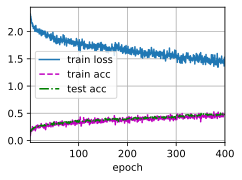

In [11]:
from d2l import torch as d2l
%matplotlib inline

# 训练和验证模型
num_epochs, lr = 400, 1e-2
device, lr_period, lr_decay, net = d2l.try_gpu(), 100, 0.7, swin_transformer_t
train_ch6(net, train_iter, train_valid_iter, lr, num_epochs, device, lr_period,
      lr_decay)

本次测试使用的是之前用李沐老师书中的包构建的超小CIFAR10数据集，测试目的在于将手写SwinTransformer模型跑通，可以看到粗略调参后精度在0.5左右，这个结果只能图个乐了（另外本次测试没有构建和使用drop path层）。不过可以看出模型远没有收敛，训练了400个epoch后也没有一点over fitting的情况出现，众所周知transformer类的模型没有了cnn模型的先验知识及归纳偏置，在小型数据集上表现远不如cnn，由于没有卡实验就暂时告一段落了。

#### 6、相对位置编码的可视化

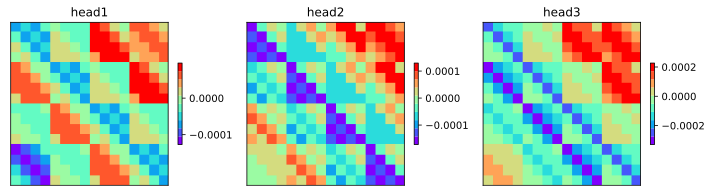

In [79]:
import numpy as np  
from matplotlib import pyplot as plt  
from matplotlib import cm   
from matplotlib import axes

index = swin_transformer_t.stage1.block_msa[1].pos_index.data.detach()
bias_table = swin_transformer_t.stage1.block_msa[1].pos_table.data.detach()
pos_bias = bias_table[:, index].to("cpu").permute(1,2,0)

# figure=plt.figure(facecolor='w')
plt.figure(figsize=(12,3), dpi=80)
cmap=cm.get_cmap('rainbow',10)   
ax=plt.subplot(1,3,1)
ax.set_title("head1")
ax.set_xticks([])
ax.set_yticks([])
mapp=ax.imshow(pos_bias[:,:,0],interpolation='nearest',cmap=cmap,aspect='auto',vmin=pos_bias[:,:,0].min(),vmax=pos_bias[:,:,0].max())  
cb=plt.colorbar(mappable=mapp,cax=None,ax=ax,shrink=0.5)
ax=plt.subplot(1,3,2)
ax.set_title("head2")
ax.set_xticks([])
ax.set_yticks([])
mapp=ax.imshow(pos_bias[:,:,1],interpolation='nearest',cmap=cmap,aspect='auto',vmin=pos_bias[:,:,1].min(),vmax=pos_bias[:,:,1].max())  
cb=plt.colorbar(mappable=mapp,cax=None,ax=ax,shrink=0.5) 
ax=plt.subplot(1,3,3)
ax.set_title("head3")
ax.set_xticks([])
ax.set_yticks([])
mapp=ax.imshow(pos_bias[:,:,2],interpolation='nearest',cmap=cmap,aspect='auto',vmin=pos_bias[:,:,2].min(),vmax=pos_bias[:,:,2].max())  
cb=plt.colorbar(mappable=mapp,cax=None,ax=None,shrink=0.5)


这里拿了训练完成后的模型的第一个stage中第一个msa中的三个head中的相对位置学习到的参数，Swin Transformer与ViT不同的是ViT是使用的位置嵌入，直接在embedding的过程中每个patch分别加上对应向量，这里是直接在自注意力的过程中添加的偏移量。拿不到表示对应元素的向量不宜做相似性分析可视化，简单的可视化这个bias的热图，可以看到大致上由主对角线向两侧渐进，且呈方格块分布,相邻列与相邻行之间在不同头之间关系有细微区别。